# Milestone Project II - SkimLet

In [1]:
# Confirm access to a GPU
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-c8bf4416-72ec-94f2-3e17-37649766df1d)


## Get data

In [2]:
 !git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
 !ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [4]:
!head -n 40 pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt

###24293578
OBJECTIVE	To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .
METHODS	A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .
METHODS	Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .
METHODS	Pain was assessed using the visual analog pain scale ( @-@ mm ) .
METHODS	Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .
METHODS	Serum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP 

In [5]:
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [6]:
# Check all of the filenames in the target dir
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

In [7]:
# Create function to read the lines of a document
def get_lines(filename):
    """
    Reads filename (a text filename) and returns the lines as a list.

    Args: 
        filename: a string containing the target filepath.

    Returns: 
        A list of string with one string per line from the target filename
    """
    with open(filename, 'r') as f:
        return f.readlines()


In [8]:
# Let's read in the training line
train_lines = get_lines(data_dir + 'train.txt')
train_lines[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [9]:
len(train_lines)

210040

Let's think about how we want our data to look...

In [10]:
def preprocess_text_with_line_number(filename):
    """Returns a list of dictionaries of abstract line data.

    Takes in filename, reads its contents and sorts through each line,
    extracting things like the target label, the text of the sentence,
    how many sentences are in the current abstract and what sentence number
    the target line is.

    Args:
        filename: a string of the target text file to read and extract line data
        from.

    Returns:
        A list of dictionaries each containing a line from an abstract,
        the lines label, the lines position in the abstract and the total number
        of lines in the abstract where the line is from. For example:

        [{"target": 'CONCLUSION',
            "text": The study couldn't have gone better, turns out people are kinder than you think",
            "line_number": 8,
            "total_lines": 8}]
    """            
    input_lines = get_lines(filename=filename)
    abstract_lines = ""
    abstract_samples = []

    # Loop throught each line in the target file
    for line in input_lines:
        if line.startswith('###'): # Check to see if line is id line
            abstract_id = line
            abstract_lines = ""

        elif line.isspace(): # Check to see if line is a new line
            abstract_line_split = abstract_lines.splitlines() 

            # Iterate through each line in a single abstract and ccount them at the same time
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {} # Create an empty dictionary fr each line
                target_text_split = abstract_line.split('\t')
                line_data['target'] = target_text_split[0] # get target label
                line_data['text']   = target_text_split[1].lower() # Get target text and lower it
                line_data['line_number'] = abstract_line_number
                line_data['total_lines'] = len(abstract_line_split) - 1 # All lines (total) in subpart
                abstract_samples.append(line_data)

        else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
            abstract_lines += line

    return abstract_samples

In [11]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_number(data_dir + "train.txt")
val_samples = preprocess_text_with_line_number(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_number(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 570 ms, sys: 112 ms, total: 682 ms
Wall time: 678 ms


In [12]:
# Check the first abstract of our training data
train_samples[:14]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [13]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(20)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [14]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

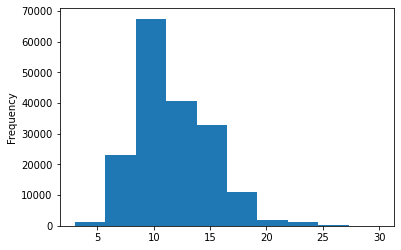

In [15]:
train_df.total_lines.plot.hist();

### Get lists of sentences
 

In [16]:
# Convert abstract text lines into lists
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [17]:
# View the first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

### Make numeric labels (ML models require numeric labels)

In [18]:
# one hot encode
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [19]:
# Label encode
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [20]:
# Get class names and number of classes from LabelEncoder instance 
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Creating a series of model experiments

### Model 0: Getting a baseline

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

model_0.fit(X=train_sentences, 
            y=train_labels_encoded)

Pipeline(memory=None,
         steps=[('tf-idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [22]:
# Evaluate baseline on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [23]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [24]:
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

### Download helper function to evaluate our model

In [25]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import calculate_results

--2021-09-24 15:53:13--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-09-24 15:53:13 (65.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [26]:
# Create baseline results
baseline_results = calculate_results(val_labels_encoded, baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Preparing our data (the text) for deep sequence model

In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [28]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

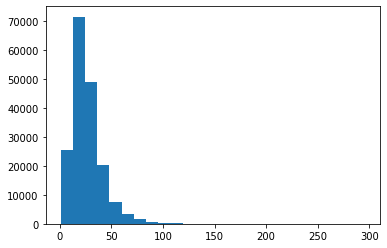

In [29]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=25)
plt.show()

In [30]:
# How long of a sentence length covers 95% percent of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [31]:
# Max sequence length in the training set
max(sent_lens)

296

### Create text vectorizer layer

In [32]:
# How many words in our vocabulary? (taken from table 2)
max_tokens = 68000

In [33]:
# Create text vectorizer 
from tensorflow.keras.layers import TextVectorization
text_vectorizer = TextVectorization(max_tokens=max_tokens, 
                                       output_sequence_length=output_seq_len)

In [34]:
# Adapt text vectorizer to training  sentences
text_vectorizer.adapt(train_sentences)

In [35]:
# Test out text_vectorizer on random sentence
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n {target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
 despite their high rates of depression , homebound older adults have limited access to evidence-based psychotherapy .

Length of text: 17

Vectorized text: [[  643   120   181   162     4   255 22960   350   266    99   665   821
      6  1439  2205     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [36]:
# how many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [37]:
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True}

### Create custom text embedding

In [38]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), 
                               output_dim=128,
                               mask_zero=True, 
                               name='token_embedding')

In [39]:
# Show example embedding
print(f"Sentence before vectorization:\n {target_sentence}")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}")
print(f"Embedding sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 despite their high rates of depression , homebound older adults have limited access to evidence-based psychotherapy .
Sentence after vectorization (before embedding):
 [[  643   120   181   162     4   255 22960   350   266    99   665   821
      6  1439  2205     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
Sentence after embedding:
 [[[ 0.04286714 -0.01461997 -0.03993144 ... -0.03266915  0.01572711
   -0.04915282]
  [-0.03545878 -0.0201079   0.00046616 ...  0.01690531  0.00276284
    0.04979593]
  [ 0.02101251 -0.03645384  0.01108117 ... -0.03885673 -0.02122769
   -0.00145422]
  ...
  [ 0.00574788  0.00922958  0.0430918  ... -0.00890341  0.03816586
   -0.03823415]
  [ 0.00574788  0.00922958  0.0430918  ... -0.00890341  0.03816586
   -0.03823415]
  [ 0.0057

## Creating datasets (making sure our data loads as fast as possible)

In [40]:
# Turn our data into TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [41]:
# Take the TensorSliceDataset's and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [42]:
train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

## Model 1: Conv1D with token embeddings


In [43]:
# Create 1D conv model to process sequence
inputs = layers.Input(shape=(1, ), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model_1 = tf.keras.Model(inputs, outputs)

# Compile model
model_1.compile(loss='categorical_crossentropy', 
                optimizer=tf.keras.optimizers.Adam(), 
                metrics=['accuracy'])

In [44]:
history_model_1 = model_1.fit(train_dataset, 
                              steps_per_epoch=int(len(train_dataset) * 0.1),
                              epochs=3, 
                              validation_data=valid_dataset, 
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 39s 14ms/step - loss: 0.9151 - accuracy: 0.6436 - val_loss: 0.6841 - val_accuracy: 0.7380
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.6571 - accuracy: 0.7588 - val_loss: 0.6294 - val_accuracy: 0.7706
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.6145 - accuracy: 0.7767 - val_loss: 0.5945 - val_accuracy: 0.7839


In [45]:
# Evaluate model on validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.5964 - accuracy: 0.7877


[0.5963639616966248, 0.7877333760261536]

In [46]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[4.5338401e-01, 1.7477417e-01, 6.2296681e-02, 2.8786105e-01,
         2.1684157e-02],
        [3.9654908e-01, 3.2691059e-01, 1.4156420e-02, 2.5337926e-01,
         9.0045789e-03],
        [1.2968855e-01, 7.3207002e-03, 1.7312949e-03, 8.6123472e-01,
         2.4738663e-05],
        ...,
        [8.3840678e-06, 8.5948908e-04, 8.8070368e-04, 3.5120968e-06,
         9.9824798e-01],
        [4.2688373e-02, 4.5790911e-01, 9.8763421e-02, 5.3051632e-02,
         3.4758747e-01],
        [1.7754097e-01, 6.7094439e-01, 5.0099760e-02, 4.9401712e-02,
         5.2013118e-02]], dtype=float32), (30212, 5))

In [47]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [48]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [49]:
# Calculate model_1 results
model_1_results = calculate_results(val_labels_encoded, model_1_preds)
model_1_results

{'accuracy': 78.7733350986363,
 'f1': 0.7853851475816208,
 'precision': 0.7848095898881569,
 'recall': 0.787733350986363}

In [50]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

In [51]:
# Evaluate model on test dataset
model_1.evaluate(test_dataset)

942/942 [==============================] - 4s 4ms/step - loss: 0.6101 - accuracy: 0.7830


[0.6101351976394653, 0.7830097675323486]

## Model 2: Feature extraction with pretrained token embeddings

Let's use Universal Sentence Encoder

In [52]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4', 
                                        trainable=False, 
                                        name='universal_sentence_encoder')

In [53]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n {use_embedded_sentence}")
print(f"Length of sentence emebedding: {len(use_embedded_sentence[0])}")

Random sentence:
 no difference was found in the progression of disability .
Sentence after embedding:
 [[-0.04281342 -0.0528108   0.05419353 -0.05734935 -0.06817179  0.02507058
   0.00474606  0.01591566  0.01780406  0.02814611  0.08572493  0.06947555
   0.05258163  0.03403963  0.06927561 -0.02079958 -0.09250191 -0.02082175
   0.00632855  0.00230851  0.04966203  0.01271385 -0.00241751  0.05846207
  -0.01628326  0.07699293  0.03436485  0.05004708  0.05337762  0.03198297
  -0.01489206  0.08630455  0.06524692 -0.01983633  0.02432723 -0.04358134
  -0.03376112 -0.02744908  0.04241002  0.03591223 -0.05028317 -0.07469939
   0.03242601  0.06629182 -0.00749692  0.0543418  -0.00988269  0.03996207
  -0.04892903 -0.06993046 -0.06300671 -0.08802464  0.00277032  0.0042836
   0.06382295 -0.02093679  0.06919062  0.02376503  0.06747011  0.02431778
  -0.00714371  0.07026696 -0.0241261   0.03459177  0.03878338 -0.06536277
  -0.0692355  -0.03595536  0.0308705   0.04555885 -0.01556447  0.02611845
  -0.0208

### Building and fitting an  NLP feature extraction model using TensorFlow Hub


In [54]:
# Define feature extraction model using TF Hub Layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation='relu')(pretrained_embedding)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_2 = tf.keras.Model(inputs, outputs, name='model_2_use_feature_extractor')

# compile the model
model_2.compile(loss='categorical_crossentropy', 
                optimizer=tf.keras.optimizers.Adam(), 
                metrics=['accuracy'])

In [55]:
model_2.summary()

Model: "model_2_use_feature_extractor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
universal_sentence_encoder ( (None, 512)               256797824 
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [56]:
# Fit model_2 to the data
history_model_2 = model_2.fit(train_dataset, 
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_dataset)), 
                              validation_data=valid_dataset, 
                              validation_steps=int(0.1* len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 13s 19ms/step - loss: 0.9174 - accuracy: 0.6485 - val_loss: 0.7970 - val_accuracy: 0.6898
Epoch 2/3
562/562 [==============================] - 10s 18ms/step - loss: 0.7693 - accuracy: 0.7016 - val_loss: 0.7545 - val_accuracy: 0.7048
Epoch 3/3
562/562 [==============================] - 10s 18ms/step - loss: 0.7532 - accuracy: 0.7112 - val_loss: 0.7383 - val_accuracy: 0.7158


In [57]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 15s 15ms/step - loss: 0.7413 - accuracy: 0.7143


[0.7413095831871033, 0.7142857313156128]

In [58]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[0.41267267, 0.3857232 , 0.00242768, 0.19276729, 0.00640916],
       [0.34771186, 0.50129336, 0.00261812, 0.1463877 , 0.00198897],
       [0.2538907 , 0.13586763, 0.01755509, 0.5543908 , 0.03829581],
       ...,
       [0.00191792, 0.00682061, 0.05740249, 0.00099142, 0.9328675 ],
       [0.00424445, 0.0506563 , 0.18055244, 0.00150703, 0.7630398 ],
       [0.25391594, 0.24462718, 0.42812192, 0.00847187, 0.06486316]],
      dtype=float32)

In [59]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [60]:
# Calculate results from TF Hub pretrained embedding on val set
model_2_results = calculate_results(val_labels_encoded, model_2_preds)
model_2_results

{'accuracy': 71.42857142857143,
 'f1': 0.711264601259711,
 'precision': 0.7149667535407679,
 'recall': 0.7142857142857143}

## Model 3: Conv1D with character embeddings

### Creating a character level tokenizer

In [61]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [62]:
# Make function to split sentence into character
def split_char(text):
    return " ".join(text)

# Text splitting non-character-level sequnce into character
split_char(random_train_sentence)

'n o   d i f f e r e n c e   w a s   f o u n d   i n   t h e   p r o g r e s s i o n   o f   d i s a b i l i t y   .'

In [63]:
# Split sequence level data split into character level data split
train_chars = [split_char(sentence) for sentence in train_sentences]
val_chars = [split_char(sentence) for sentence in val_sentences]
test_chars = [split_char(sentence) for sentence in test_sentences]

In [64]:
# What's the avg character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([2.2108e+04, 7.0583e+04, 5.3952e+04, 2.2391e+04, 7.4540e+03,
        2.2350e+03, 8.0200e+02, 2.8700e+02, 1.1800e+02, 4.9000e+01,
        2.9000e+01, 1.3000e+01, 8.0000e+00, 5.0000e+00, 1.0000e+00,
        2.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.00000e+00, 7.02500e+01, 1.39500e+02, 2.08750e+02, 2.78000e+02,
        3.47250e+02, 4.16500e+02, 4.85750e+02, 5.55000e+02, 6.24250e+02,
        6.93500e+02, 7.62750e+02, 8.32000e+02, 9.01250e+02, 9.70500e+02,
        1.03975e+03, 1.10900e+03, 1.17825e+03, 1.24750e+03, 1.31675e+03,
        1.38600e+03]),
 <a list of 20 Patch objects>)

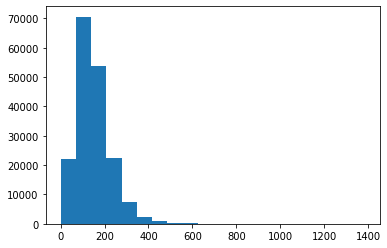

In [65]:
# Check the distribution of the sequence at a character level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=20)

In [66]:
# Find what character length covers 95% of sequence
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [67]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [68]:
# Create char-level token vectoizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len, 
                                    name='char_vectorizer')

In [69]:
# Adapt charactter vectorizer to training character
char_vectorizer.adapt(train_chars)

In [70]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [71]:
# Test out char vectorizer
random_train_char = random.choice(train_chars)
print(f"Charaified text:\n {random_train_char}")
print(f"Length of charaified text:\n {len(random_train_char.split())}")
vectorized_char = char_vectorizer([random_train_char])
print(f"Vectorized Chars: \n{vectorized_char}")
print(f"Length of vectorized chars {len(vectorized_char[0])}")

Charaified text:
 t h e   e r a d i c a t i o n   r a t e s   b y   i n t e n t i o n - t o - t r e a t   a n a l y s i s   w e r e   @   %   (   @   %   c i   :   @ - @   @   ;   @   o f   @   p a t i e n t s   )   ,   @   %   (   @   %   c i   :   @ - @   @   ;   @   o f   @   p a t i e n t s   )   ,   a n d   @   %   (   @   %   c i   :   @ - @   @   ;   @   o f   @   p a t i e n t s   )   i n   t h e   @ - d a y   p p i   t r i p l e   ,   @ - d a y   a n d   @ - d a y   s e q u e n t i a l   t h e r a p y   g r o u p s   ,   r e s p e c t i v e l y   (   p   =   @   )   .
Length of charaified text:
 209
Vectorized Chars: 
[[ 3 13  2  2  8  5 10  4 11  5  3  4  7  6  8  5  3  2  9 22 19  4  6  3
   2  6  3  4  7  6  3  7  3  8  2  5  3  5  6  5 12 19  9  4  9 20  2  8
   2 11  4  7 17 14  5  3  4  2  6  3  9 11  4  7 17 14  5  3  4  2  6  3
   9  5  6 10 11  4  7 17 14  5  3  4  2  6  3  9  4  6  3 13  2 10  5 19
  14 14  4  3  8  4 14 12  2 10  5 19  5  6 10 10  5 19  9  2 26 16  

### Creating a character-level embedding

In [72]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25, 
                              mask_zero=True,
                              name='char_embed')

In [73]:
# Test out character embedding layer
print(f"Charified text:\n{random_train_char}")
char_embed_example = char_embed(char_vectorizer([random_train_char]))
print(f"Embedding chars: \n{char_embed_example}")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
t h e   e r a d i c a t i o n   r a t e s   b y   i n t e n t i o n - t o - t r e a t   a n a l y s i s   w e r e   @   %   (   @   %   c i   :   @ - @   @   ;   @   o f   @   p a t i e n t s   )   ,   @   %   (   @   %   c i   :   @ - @   @   ;   @   o f   @   p a t i e n t s   )   ,   a n d   @   %   (   @   %   c i   :   @ - @   @   ;   @   o f   @   p a t i e n t s   )   i n   t h e   @ - d a y   p p i   t r i p l e   ,   @ - d a y   a n d   @ - d a y   s e q u e n t i a l   t h e r a p y   g r o u p s   ,   r e s p e c t i v e l y   (   p   =   @   )   .
Embedding chars: 
[[[-0.03972482  0.01346913  0.00081969 ... -0.02374094 -0.04705718
    0.03296808]
  [-0.00044499  0.04875388  0.01745243 ... -0.0367034   0.03898989
   -0.04362714]
  [ 0.03239629  0.03021211  0.01402608 ...  0.03525776  0.01495475
   -0.04620143]
  ...
  [-0.04212784  0.04918585 -0.03049741 ...  0.04571021 -0.04353885
   -0.02993871]
  [-0.04212784  0.04918585 -0.03049741 ...  0.04571021 -0.0435

### Building a Conv1D model to fit the character embedding

In [74]:
# Make conv1D on chars only
inputs = layers.Input(shape=(1, ), dtype='string')
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_3 = tf.keras.Model(inputs=inputs, 
                         outputs=outputs, 
                         name='model_3_conv1d_char_embeddings')

# Compile 
model_3.compile(loss='categorical_crossentropy', 
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [75]:
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
char_vectorizer (TextVectori (None, 290)               0         
_________________________________________________________________
char_embed (Embedding)       (None, 290, 25)           700       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 290, 64)           8064      
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
__________________________________

In [76]:
# Create char level datasets (Prefetch)
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [77]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset, 
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 6s 10ms/step - loss: 1.2550 - accuracy: 0.4887 - val_loss: 1.0448 - val_accuracy: 0.5755
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 1.0044 - accuracy: 0.5985 - val_loss: 0.9436 - val_accuracy: 0.6240
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.9298 - accuracy: 0.6333 - val_loss: 0.8742 - val_accuracy: 0.6632


In [78]:
# Make prediction with character level only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.23786265, 0.38307735, 0.03738583, 0.3126155 , 0.02905858],
       [0.3045633 , 0.33981708, 0.0096593 , 0.33398604, 0.01197429],
       [0.11171765, 0.10580678, 0.23697269, 0.514917  , 0.03058584],
       ...,
       [0.03341952, 0.07913224, 0.27860156, 0.06387468, 0.544972  ],
       [0.03550923, 0.04767395, 0.5644434 , 0.04468818, 0.30768526],
       [0.422906  , 0.4614805 , 0.0444806 , 0.04533159, 0.02580135]],
      dtype=float32)

In [79]:
# Conver prediction probs to class labels
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 2, 1])>

In [80]:
# Calculate results for Conv1D model chars onlu
model_3_results = calculate_results(val_labels_encoded, 
                                    model_3_preds)
model_3_results

{'accuracy': 65.13636965444194,
 'f1': 0.6421235319294766,
 'precision': 0.6479597511235119,
 'recall': 0.6513636965444194}

## Model 4: Combining pretrained token embedding + Character embedding (hybrid model)

1. Create a token-level model (similar to model_1)
2. Create a character-level model (similar to model_3 with a slight modification to reflect the paper)
3. Combine (using layers.Concatenate) the outputs of 1 and 2
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [81]:
# 1. Setup the token embedding
token_inputs = layers.Input(shape=[], dtype='string', name='token_input')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Setups char inputs/model
char_inputs = layers.Input(shape=(1, ), dtype='string', name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs, 
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output, 
                                                                  char_model.output])

# 4. Create output layers 
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation='softmax')(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input], 
                         outputs=output_layer, 
                         name='model_4_token_char_embeddings')

In [82]:
model_4.summary()

Model: "model_4_token_char_embeddings"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_input (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_input[0][0]                 
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_input[0][0]                
______________________________________________________________________

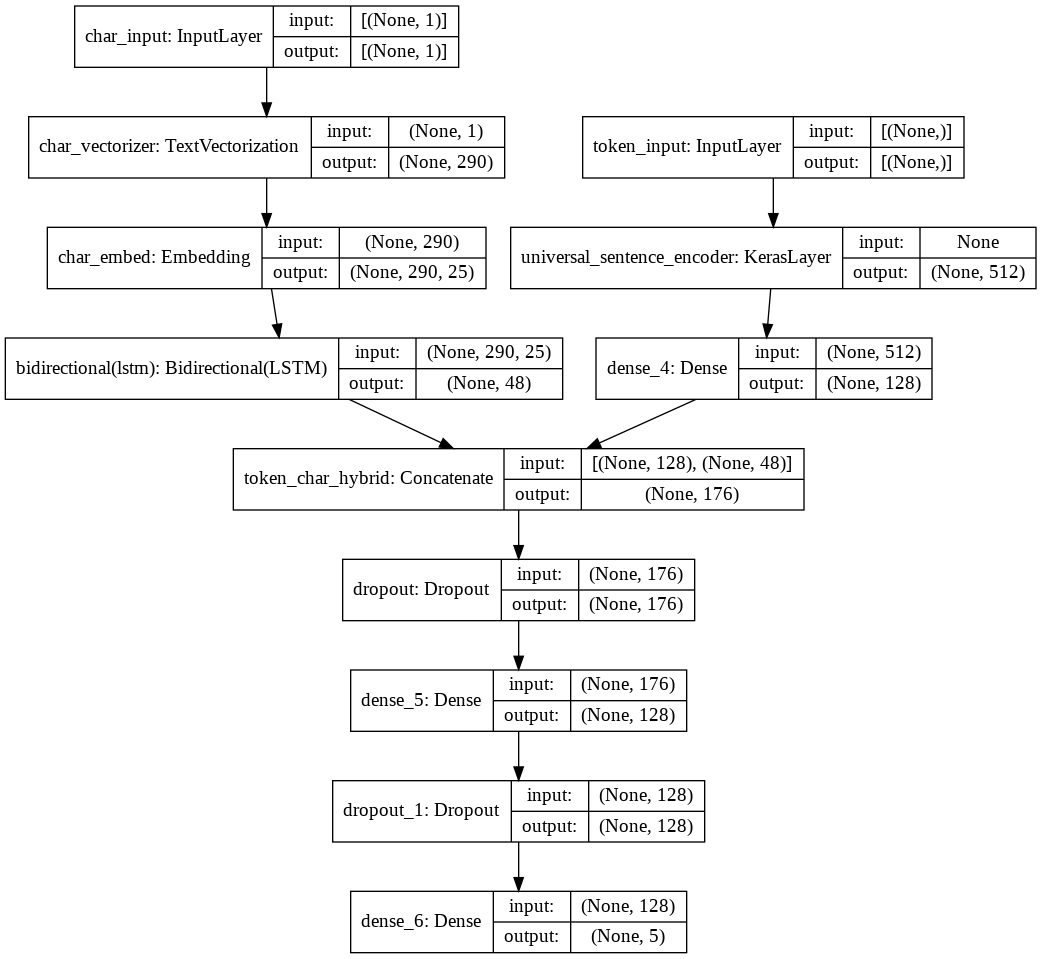

In [83]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [84]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), 
                metrics=["accuracy"])

#### Combining token and character data into a tf.data dataset

In [85]:
# Combine chars and tokens into a dataset
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_token_char_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_token_char_dataset = tf.data.Dataset.zip((train_token_char_data, train_token_char_labels))

# Prefetch and batch train data
train_token_char_dataset = train_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat same steps validation data
val_token_char_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_token_char_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_token_char_dataset = tf.data.Dataset.zip((val_token_char_data, val_token_char_labels))
val_token_char_dataset = val_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [86]:
# Check out training char and token embedding dataset
train_token_char_dataset, val_token_char_dataset

(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)

### Fitting a model on token and character-level sequences

In [87]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_token_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_token_char_dataset)),
                              epochs=3,
                              validation_data=val_token_char_dataset,
                              validation_steps=int(0.1 * len(val_token_char_dataset)))

Epoch 1/3
562/562 [==============================] - 83s 130ms/step - loss: 0.9848 - accuracy: 0.6075 - val_loss: 0.7894 - val_accuracy: 0.6971
Epoch 2/3
562/562 [==============================] - 70s 124ms/step - loss: 0.7991 - accuracy: 0.6924 - val_loss: 0.7129 - val_accuracy: 0.7307
Epoch 3/3
562/562 [==============================] - 67s 119ms/step - loss: 0.7689 - accuracy: 0.7040 - val_loss: 0.6894 - val_accuracy: 0.7384


In [88]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_token_char_dataset)

945/945 [==============================] - 48s 51ms/step - loss: 0.6949 - accuracy: 0.7345


[0.6949188113212585, 0.7345425486564636]

In [89]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_token_char_dataset)
model_4_pred_probs

array([[4.0087563e-01, 3.8914761e-01, 3.5509970e-03, 2.0190661e-01,
        4.5192582e-03],
       [3.6114514e-01, 4.0357375e-01, 2.9628689e-03, 2.3080087e-01,
        1.5173613e-03],
       [2.8924420e-01, 1.6009270e-01, 5.3735245e-02, 4.6579337e-01,
        3.1134438e-02],
       ...,
       [2.7949273e-04, 5.0084158e-03, 3.8219243e-02, 9.1520611e-05,
        9.5640141e-01],
       [4.7345553e-03, 4.8271228e-02, 1.9424736e-01, 2.3371077e-03,
        7.5040972e-01],
       [3.1792018e-01, 2.8818318e-01, 2.7598345e-01, 3.9751381e-02,
        7.8161865e-02]], dtype=float32)

In [90]:
# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 0])>

In [91]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.4542565867867,
 'f1': 0.7325738436102652,
 'precision': 0.7345138918354077,
 'recall': 0.734542565867867}

## Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

In [92]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


## Create positional embeddings

In [93]:
# How many different line numbers are there
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

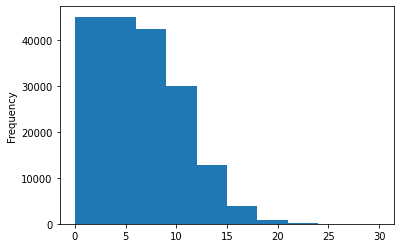

In [94]:
# Check the distribution of "line_number" column
train_df['line_number'].plot.hist()

In [96]:
# Use tensorflow to create one-hot-encoded tensors of our "line_number" column
train_line_num_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_num_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_num_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)
train_line_num_one_hot[:10], train_line_num_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

In [97]:
# How many different number of lines are there
train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

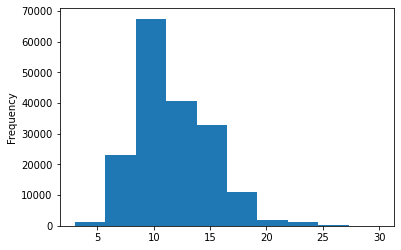

In [98]:
# Check the distributions of total lines
train_df.total_lines.plot.hist();

In [99]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 95)

18.0

In [103]:
# Use Tensorflow to onehotencode total_lines feature
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)
train_total_lines_one_hot[:10], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

### Building a tribrid embedding model

1. Create a token-level model (similar to model_1)
2. Create a character-level model (similar to model_3 with a slight modification to reflect the paper)
3. Create a "line_number" model (takes in one-hot-encoded "line_number" tensor and passes it through a non-linear layer)
4. Create a "total_lines" model (takes in one-hot-encoded "total_lines" tensor and passes it through a non-linear layer)
5. Combine (using layers.Concatenate) the outputs of 1 and 2 into a token-character-hybrid embedding and pass it series of output to Figure 1 and section 4.2 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts
6. Combine (using layers.Concatenate) the outputs of 3, 4 and 5 into a token-character-positional tribrid embedding
7. Create an output layer to accept the tribrid embedding and output predicted label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a tf.keras.Model

In [110]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_embeddings)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, 
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input, 
                                 char_model.input],
                         outputs=output_layer)

In [112]:
# Get a summary of our token, char and positional embedding model
model_5.summary()

Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_inputs[0][0]                
__________________________________________________________________________________________________
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
char_embed (Embedding)          (None, 290, 25)      700         char_vectorizer[6][0]            
___________________________________________________________________________________________

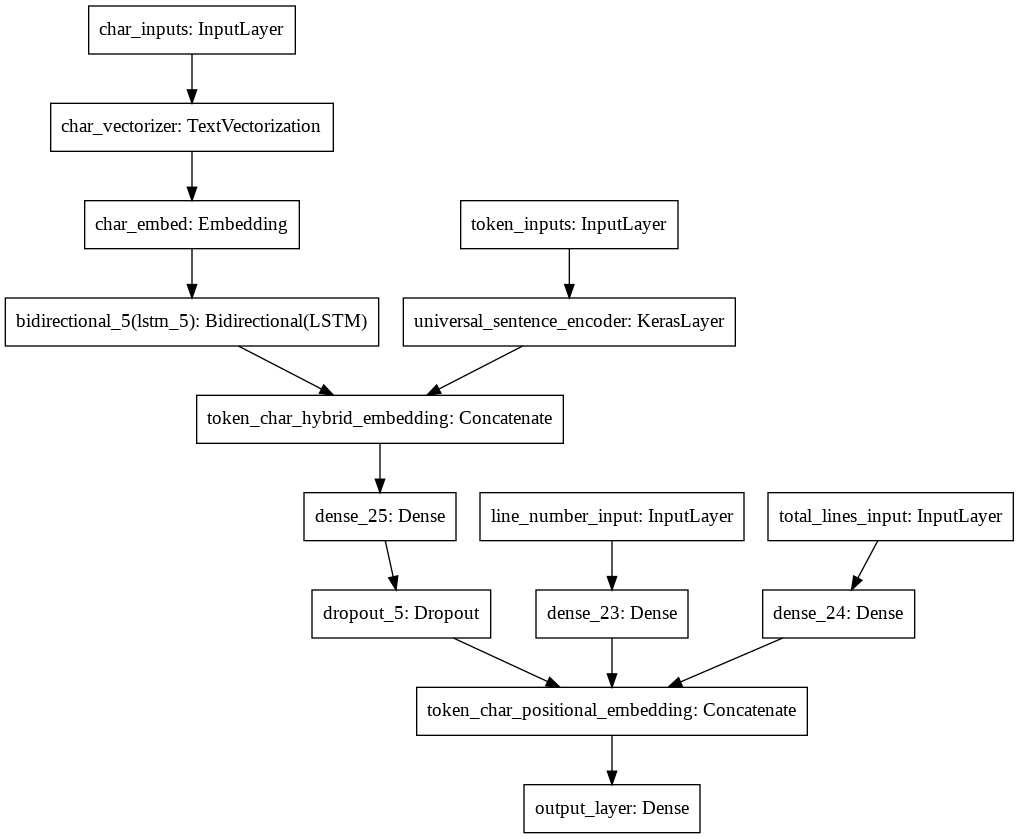

In [111]:
plot_model(model_5)

In [113]:
# Check which layers of our model are trainable or not
for layer in model_5.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f94653151d0> True
<keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x7f947fa4db90> True
<keras.engine.input_layer.InputLayer object at 0x7f94652b5850> True
<keras.layers.embeddings.Embedding object at 0x7f9483c9c710> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7f94fc5500d0> False
<keras.layers.wrappers.Bidirectional object at 0x7f9465bf4a50> True
<keras.layers.merge.Concatenate object at 0x7f9465c6ec50> True
<keras.engine.input_layer.InputLayer object at 0x7f9465506c90> True
<keras.engine.input_layer.InputLayer object at 0x7f9464bac550> True
<keras.layers.core.Dense object at 0x7f9465156850> True
<keras.layers.core.Dense object at 0x7f9465875f90> True
<keras.layers.core.Dense object at 0x7f94654a1ad0> True
<keras.layers.core.Dropout object at 0x7f9465c6eb50> True
<keras.layers.merge.Concatenate object at 0x7f9464bb9c50> True
<keras.layers.core.Dense object at 0x7f9464bbe990> True


In [114]:
# Compile the model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

#### Create tribrid embedding datasets and fit tribrid model

In [116]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_num_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_num_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

### Fitting and evaluating model

In [120]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 83s 131ms/step - loss: 1.0999 - accuracy: 0.7229 - val_loss: 0.9827 - val_accuracy: 0.8068
Epoch 2/3
562/562 [==============================] - 70s 125ms/step - loss: 0.9752 - accuracy: 0.8121 - val_loss: 0.9581 - val_accuracy: 0.8185
Epoch 3/3
562/562 [==============================] - 67s 119ms/step - loss: 0.9605 - accuracy: 0.8187 - val_loss: 0.9489 - val_accuracy: 0.8268


In [121]:
# Make predictions with token-char-positional hybrid model
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 49s 49ms/step


array([[0.5225545 , 0.12259989, 0.01033689, 0.3243579 , 0.02015073],
       [0.55120647, 0.09751068, 0.04216275, 0.29950273, 0.0096174 ],
       [0.28477934, 0.13023609, 0.13966435, 0.3708858 , 0.07443441],
       ...,
       [0.04162937, 0.11257195, 0.04664585, 0.03382923, 0.76532364],
       [0.0311242 , 0.36895663, 0.09669255, 0.02418447, 0.4790421 ],
       [0.1289658 , 0.5589649 , 0.18324302, 0.03248507, 0.09634117]],
      dtype=float32)

In [122]:
# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [123]:
# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 82.92069376406725,
 'f1': 0.8280924745347503,
 'precision': 0.8274411918793138,
 'recall': 0.8292069376406725}

## Compare model results

In [124]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.773335,0.784810,0.787733,0.785385
pretrained_token_embed,71.428571,0.714967,0.714286,0.711265
custom_char_embed_conv1d,65.136370,0.647960,0.651364,0.642124
hybrid_char_token_embed,73.454257,0.734514,0.734543,0.732574
tribrid_pos_char_token_embed,82.920694,0.827441,0.829207,0.828092


In [125]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

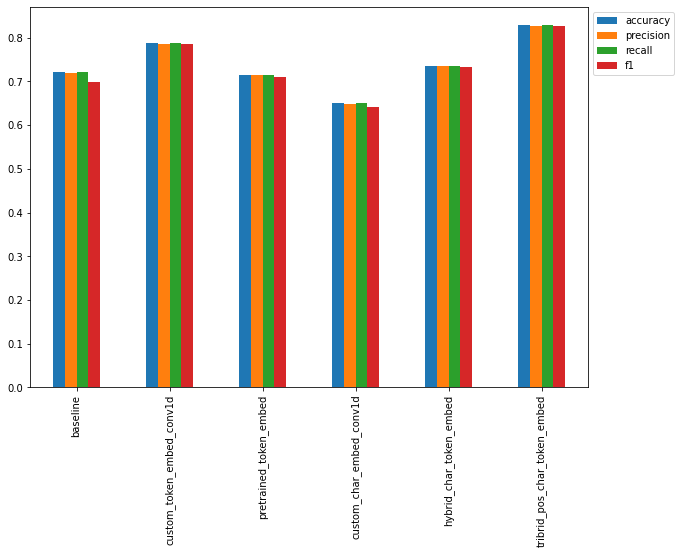

In [126]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar",
                       figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

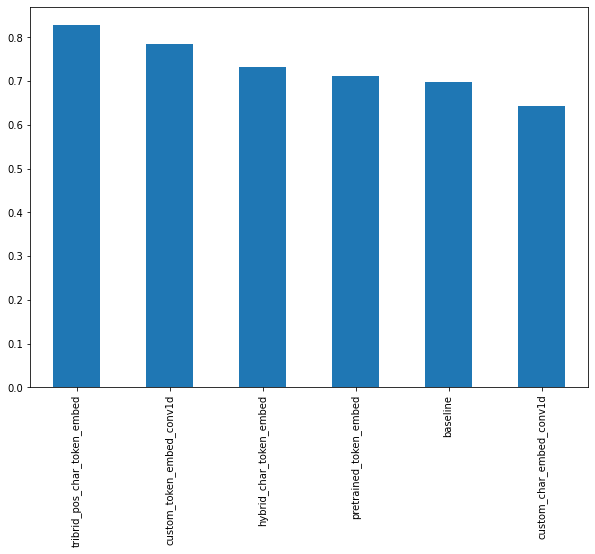

In [127]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

In [128]:
# Save best performing model to SavedModel format (default)
model_5.save("/content/drive/MyDrive/Colab Notebooks/Models/skimlit_tribrid_model") # model will be saved to path specified by string

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Models/skimlit_tribrid_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Models/skimlit_tribrid_model/assets


### Evaluate model on test dataset

In [130]:
# Create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_num_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset

<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>

In [132]:
# Make predictions on the test dataset
test_pred_probs = model_5.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 47s 49ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 3, 2, 2, 4, 4, 4, 1, 4, 0])>

In [133]:
# Evaluate loaded model test predictions
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
loaded_model_test_results

{'accuracy': 82.4622531939605,
 'f1': 0.8234252897080683,
 'precision': 0.8229205683117515,
 'recall': 0.8246225319396051}

### Find most wrong

In [134]:
%%time
# Get list of class names of test predictions
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes

CPU times: user 14.7 s, sys: 1.58 s, total: 16.2 s
Wall time: 14 s


In [135]:
# Create prediction-enriched test dataframe
test_df["prediction"] = test_pred_classes # create column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["target"] # create binary column for whether the prediction is right or not
test_df.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.518014,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,OBJECTIVE,0.329579,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.738537,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.653475,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.740598,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.892019,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,RESULTS,0.495430,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.414132,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,RESULTS,0.494792,False
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.523163,True


In [136]:
# Find top 100 most wrong samples (note: 100 is an abitrary number, you could go through all of them if you wanted)
top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:100]
top_100_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
16347,BACKGROUND,to evaluate the effects of the lactic acid bac...,0,12,OBJECTIVE,0.952359,False
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.934986,False
3573,RESULTS,a cluster randomised trial was implemented wit...,3,16,METHODS,0.929345,False
29294,RESULTS,"baseline measures included sociodemographics ,...",4,13,METHODS,0.920647,False
1221,RESULTS,data were collected prospectively for @ months...,3,13,METHODS,0.920579,False
...,...,...,...,...,...,...,...
1827,CONCLUSIONS,nct@ ( clinicaltrials.gov ) .,18,18,BACKGROUND,0.821190,False
5394,RESULTS,"a randomized , double-blind , crossover study ...",3,12,METHODS,0.820865,False
12459,RESULTS,adherence to follow-up was measured .,4,13,METHODS,0.820489,False
8527,OBJECTIVE,participants were randomly allocated to a trea...,2,10,METHODS,0.820323,False


In [137]:
# Investigate top wrong preds
for row in top_100_wrong[0:10].itertuples(): # adjust indexes to view different samples
  _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: BACKGROUND, Pred: OBJECTIVE, Prob: 0.9523593783378601, Line number: 0, Total lines: 12

Text:
to evaluate the effects of the lactic acid bacterium lactobacillus salivarius on caries risk factors .

-----

Target: CONCLUSIONS, Pred: METHODS, Prob: 0.9349863529205322, Line number: 4, Total lines: 6

Text:
symptom outcomes will be assessed and estimates of cost-effectiveness made .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.929344892501831, Line number: 3, Total lines: 16

Text:
a cluster randomised trial was implemented with @,@ children in @ government primary schools on the south coast of kenya in @-@ .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9206468462944031, Line number: 4, Total lines: 13

Text:
baseline measures included sociodemographics , standardized anthropometrics , asthma control test ( act ) , gerd symptom assessment scale , pittsburgh sleep quality index , and berlin questionnaire for sleep apnea .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9205790